<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/DL/metrics/VisualizationCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation Visualizations
## For 3D Convolutional Neural Network on Group Brain fMRI

This notebook creates visualizations from metrics returned from the CNN in the Group3DCNN file. It interprets the training and testing phase of the CNN as well as creates a simple visual explaining the test subject's experience in the scanner.You should be able to run this file locally cloning the github repository. 

Note: Some of the data imports were deprecated, hence missing training data in the training visualizations.

## Clone Repository

In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git

# Change directory into cloned repo DL folder
%cd teambrainiac/source/DL/metrics

# !ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 2231, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 2231 (delta 62), reused 0 (delta 0), pack-reused 2125
Receiving objects: 100% (2231/2231), 151.08 MiB | 12.20 MiB/s, done.
Resolving deltas: 100% (1453/1453), done.
/content/teambrainiac/source/DL/metrics


## Import Packages

In [3]:
# General Library Imports
import scipy.io
import pickle
import numpy as np
import pandas as pd
import tqdm
import random

from visualization_functions import *

import matplotlib.pyplot as plt
import altair as alt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve

## Patient Time in Scanner

In [4]:
patient_status_df = pd.read_csv('./data/patient_status_in_scanner.csv')

reg_in_scanner = alt.Chart(patient_status_df).mark_tick(thickness=5, size=50).encode(
    x = 'image_index:Q',
    color = alt.Color('Patient Status:N', scale=alt.Scale(
        domain = ['Buffer (No Regulation)', 'Up Regulation', 'Down Regulation'],
        range = ['grey', '#446CCF', '#F58518'])
    )
).properties(
    width = 800,
    height = 100,
    title = 'Patient Regulation in Scanner'
)

reg_in_scanner

alt.Chart(...)

## Model Training
Recall the data was split into 4 files on AWS to save RAM. To further save RAM, each training file was split into two. 

The first training round went through each of the 8 partitions (4 files x 2 splits) for 10 epochs. See below that the model began to train faster on later partitions of the data, but with sustained low accuracies accuracies on the first epoch of each partition. We implemented early stopping to avoid overfitting when any batch of images achieved a perfect accuracy.

To further avoid overfitting on partitions, we ran a second training round through the data with only a single epoch for each partition. You can see the training results below.

In [5]:
first_training_round = pd.read_csv('./data/10_epochs.csv')

first_training_accuracies = alt.Chart(first_training_round).mark_line().encode(
    x='epoch:O',
    y='accuracy:Q',
    color='test_set:N'
).properties(
    title='First Round Training Accuracies by Epoch',
    width=400
)

first_training_accuracies

alt.Chart(...)

In [6]:
second_training_round = pd.read_csv('./data/final_train_epochs.csv')
second_training_round['partition'] = second_training_round['index']


second_training_boxplots = alt.Chart(second_training_round).mark_boxplot(extent='min-max', size=35).encode(
    x='partition:O',
    y=alt.Y('accuracy:Q', scale=alt.Scale(domain=[0.5,1]))
).properties(
    width=400,
    title='Second Round Training Accuracies by Partition'
)

second_training_boxplots

alt.Chart(...)

## Test Metrics

In [7]:
test = pickle.load(open('./data/test_metrics.pkl', 'rb'))

In [8]:
subject_number = [int(x/2) for x in range(2,14)]
accuracies = [x.item() for x in test['epoch_1']['accuracy']]
loss = [x.item() for x in test['epoch_1']['loss']]
scatter_df = pd.DataFrame(np.array([subject_number, accuracies, loss]).T, columns = ['subject', 'accuracy', 'loss'])

test_scatter = alt.Chart(scatter_df).mark_circle(size=80).encode(
    x = alt.X('accuracy:Q', scale=alt.Scale(domain=[0,1])),
    y = alt.Y('loss:Q', scale=alt.Scale(domain=[0,1.2])),
    color = 'subject:N'
).properties(
    title='Test Set Accuracy and Loss by Subject'
)
test_scatter

alt.Chart(...)

In [9]:
best_index, worst_index = find_best_worst_index(test)
print('Best', best_index)
print('Worst', worst_index)

Best 7
Worst 9


In [10]:
best_preds = process_predictions(test, best_index)
mid_preds = process_predictions(test, 11)
worst_preds = process_predictions(test, worst_index)

Best ROC AUC Score = 91.61%
Best ROC AUC Score = 68.027%
Worst ROC AUC Score = 49.943%



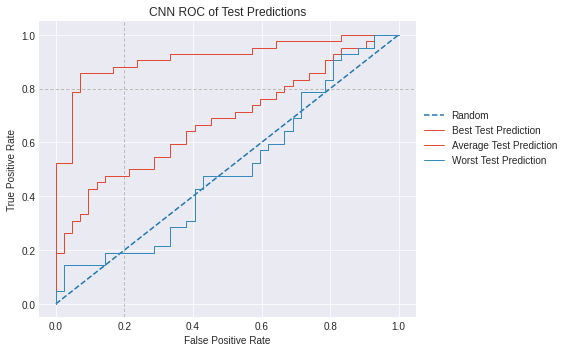

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Label Objects
true_label = best_preds['True Label']
best_probs = best_preds['Prediction']
mid_probs = mid_preds['Prediction']
worst_probs = worst_preds['Prediction']
random_probs = [0 for _ in range(len(true_label))]

# Calculate AUC scores
best_auc = roc_auc_score(true_label, best_probs)
mid_auc = roc_auc_score(true_label, mid_probs)
worst_auc = roc_auc_score(true_label,worst_probs)
print(f'Best ROC AUC Score = {best_auc*100:{.5}}%')
print(f'Best ROC AUC Score = {mid_auc*100:{.5}}%')
print(f'Worst ROC AUC Score = {worst_auc*100:{.5}}%\n')
 
# Creat Plot
random_fpr, random_tpr, _ = roc_curve(true_label, random_probs)
best_fpr, best_tpr, _ = roc_curve(true_label, best_probs)
mid_fpr, mid_tpr, _ = roc_curve(true_label, mid_probs)
worst_fpr, worst_tpr, _ = roc_curve(true_label, worst_probs)

# Change the style of plot
fig = plt.figure(figsize = (8, 5))
plt.style.use('seaborn-darkgrid')
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.2, c='gray', ls="--", lw=1, alpha=0.5)

# plot the roc curve for the model
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
plt.plot(best_fpr, best_tpr, marker='', label='Best Test Prediction', color = '#e24a33', lw = 1)
plt.plot(mid_fpr, mid_tpr, marker='', label='Average Test Prediction', color = '#e24a33', lw = 1)
plt.plot(worst_fpr, worst_tpr, marker='', label='Worst Test Prediction', color = "#348abd", lw = 1)


# # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"CNN ROC of Test Predictions")
lgd = plt.legend(loc=(1.01, 0.5))

roc_plot = plt.tight_layout()

roc_plot

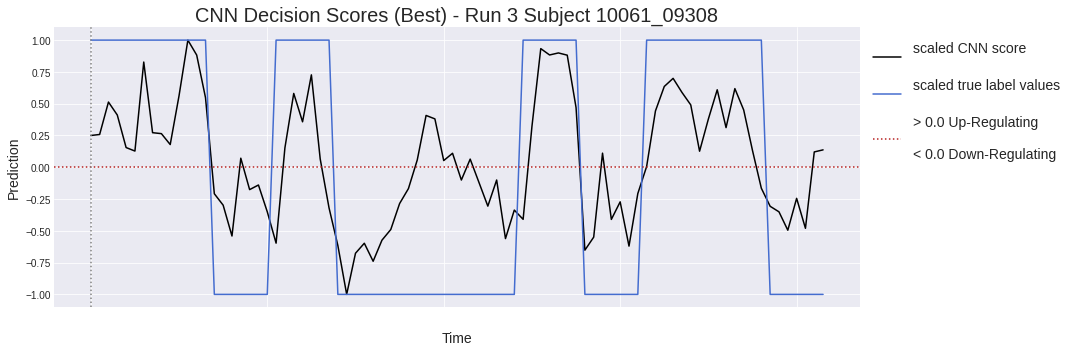

In [12]:
best_plot_title = 'CNN Decision Scores (Best) - Run 3 Subject 10061_09308'
best_plot = plot_decisions(best_preds['Prediction'],best_preds['True Label'], time=best_preds['Time'], title=best_plot_title, run=3)
best_plot

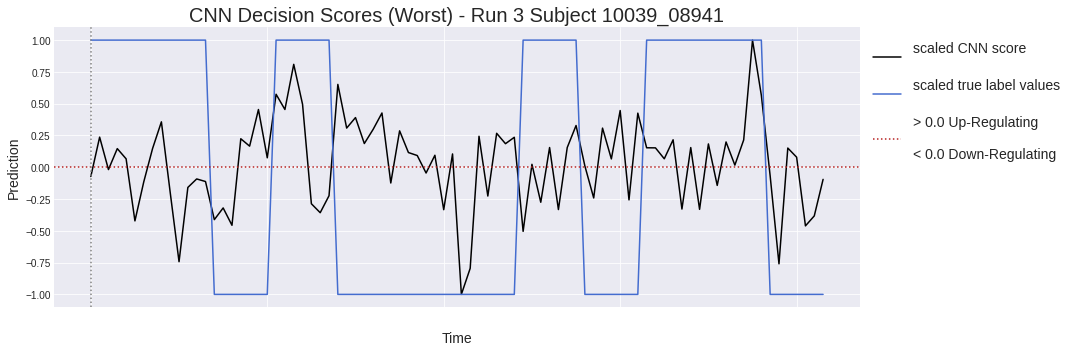

In [13]:
worst_plot_title = 'CNN Decision Scores (Worst) - Run 3 Subject 10039_08941'
worst_plot = plot_decisions(worst_preds['Prediction'],worst_preds['True Label'], time=best_preds['Time'], title=worst_plot_title, run=3)
worst_plot